In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np
from h3 import h3
import folium
from folium.plugins import HeatMap
import matplotlib.colors as colors
import branca.colormap as cm

In [2]:
offers = pd.read_csv('./datasets/data_offers.csv')
orders = pd.read_csv('./datasets/data_orders.csv')
orders

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN
...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0
10712,13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.0
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0
10714,13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.0


### Q1

In [3]:
reasons = orders.groupby(['order_status_key','is_driver_assigned_key']).size().reset_index().rename(columns={0: 'count'})
order_status_mapping = {4: 'Cancelled by Client', 9: 'Cancelled by System'}
is_driver_assigned_mapping = {0: 'Before Driver Assignment', 1: 'After Driver Assignment'}
reasons['order_status_key'] = reasons['order_status_key'].replace(order_status_mapping)
reasons['is_driver_assigned_key'] = reasons['is_driver_assigned_key'].replace(is_driver_assigned_mapping)
reasons.rename(columns={'order_status_key': 'Order Status', 'is_driver_assigned_key': 'Driver Assigned', 'count': 'Count'}, inplace=True)
reasons

,Order Status,Driver Assigned,Count
0,Cancelled by Client,Before Driver Assignment,4496
1,Cancelled by Client,After Driver Assignment,2811
2,Cancelled by System,Before Driver Assignment,3406
3,Cancelled by System,After Driver Assignment,3


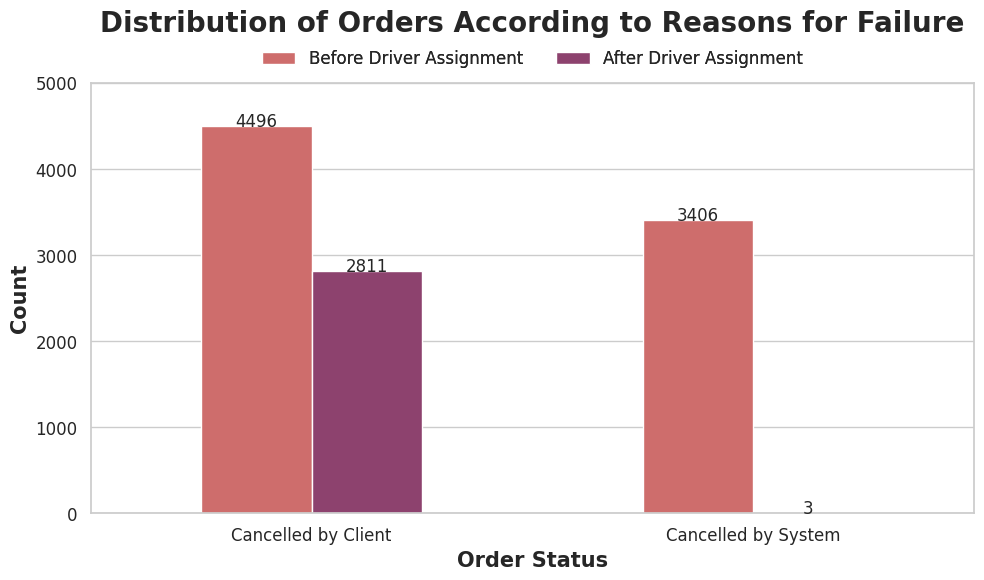

In [4]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

barplot = sns.barplot(x='Order Status', y='Count', hue='Driver Assigned', data=reasons, palette='flare', ax=ax, width=0.5)
ax.set_title('Distribution of Orders According to Reasons for Failure', fontsize=20, y=1.1,fontweight='bold')
ax.set_xlabel('Order Status', fontsize=15, fontweight='bold')
ax.set_ylabel('Count', fontsize=15, fontweight='bold')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        ax.text(x = p.get_x()+(p.get_width()/2), 
                y = height, 
                s = '{:.0f}'.format(height), 
                ha = 'center')

# sns.despine()

legend = ax.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2, title='Driver Assigned', title_fontsize='13', fontsize='12',frameon=False)
legend.set_title(None)
ax.add_artist(legend)
plt.tight_layout()
plt.ylim(0, 5000)
plt.show()

By the bar plot above we can find out that the orders cancelled by clients before Driver Assignment has the highest number of orders

## Q2

In [5]:
orders['order_hour'] = pd.to_datetime(orders['order_datetime']).dt.hour
Q2 = orders.groupby(['order_hour','order_status_key','is_driver_assigned_key']).size().unstack(level=['order_status_key', 'is_driver_assigned_key'])
Q2.columns = Q2.columns.map(lambda x: '_'.join(str(i) for i in x))
Q2.rename(columns={'4_0': 'Cancelled by Client before Driver Assigned', '4_1': 'Cancelled by Client after Driver Assigned', '9_0': 'Cancelled by System before Driver Assigned', '9_1': 'Cancelled by System after Driver Assigned'}, inplace=True)
Q2['Total'] = orders.groupby('order_hour').size()
reasons = Q2.columns
hours = Q2.index
Q2 = Q2.fillna(0)
Q2_proportion = Q2.iloc[:, :-1].div(Q2['Total'], axis=0)

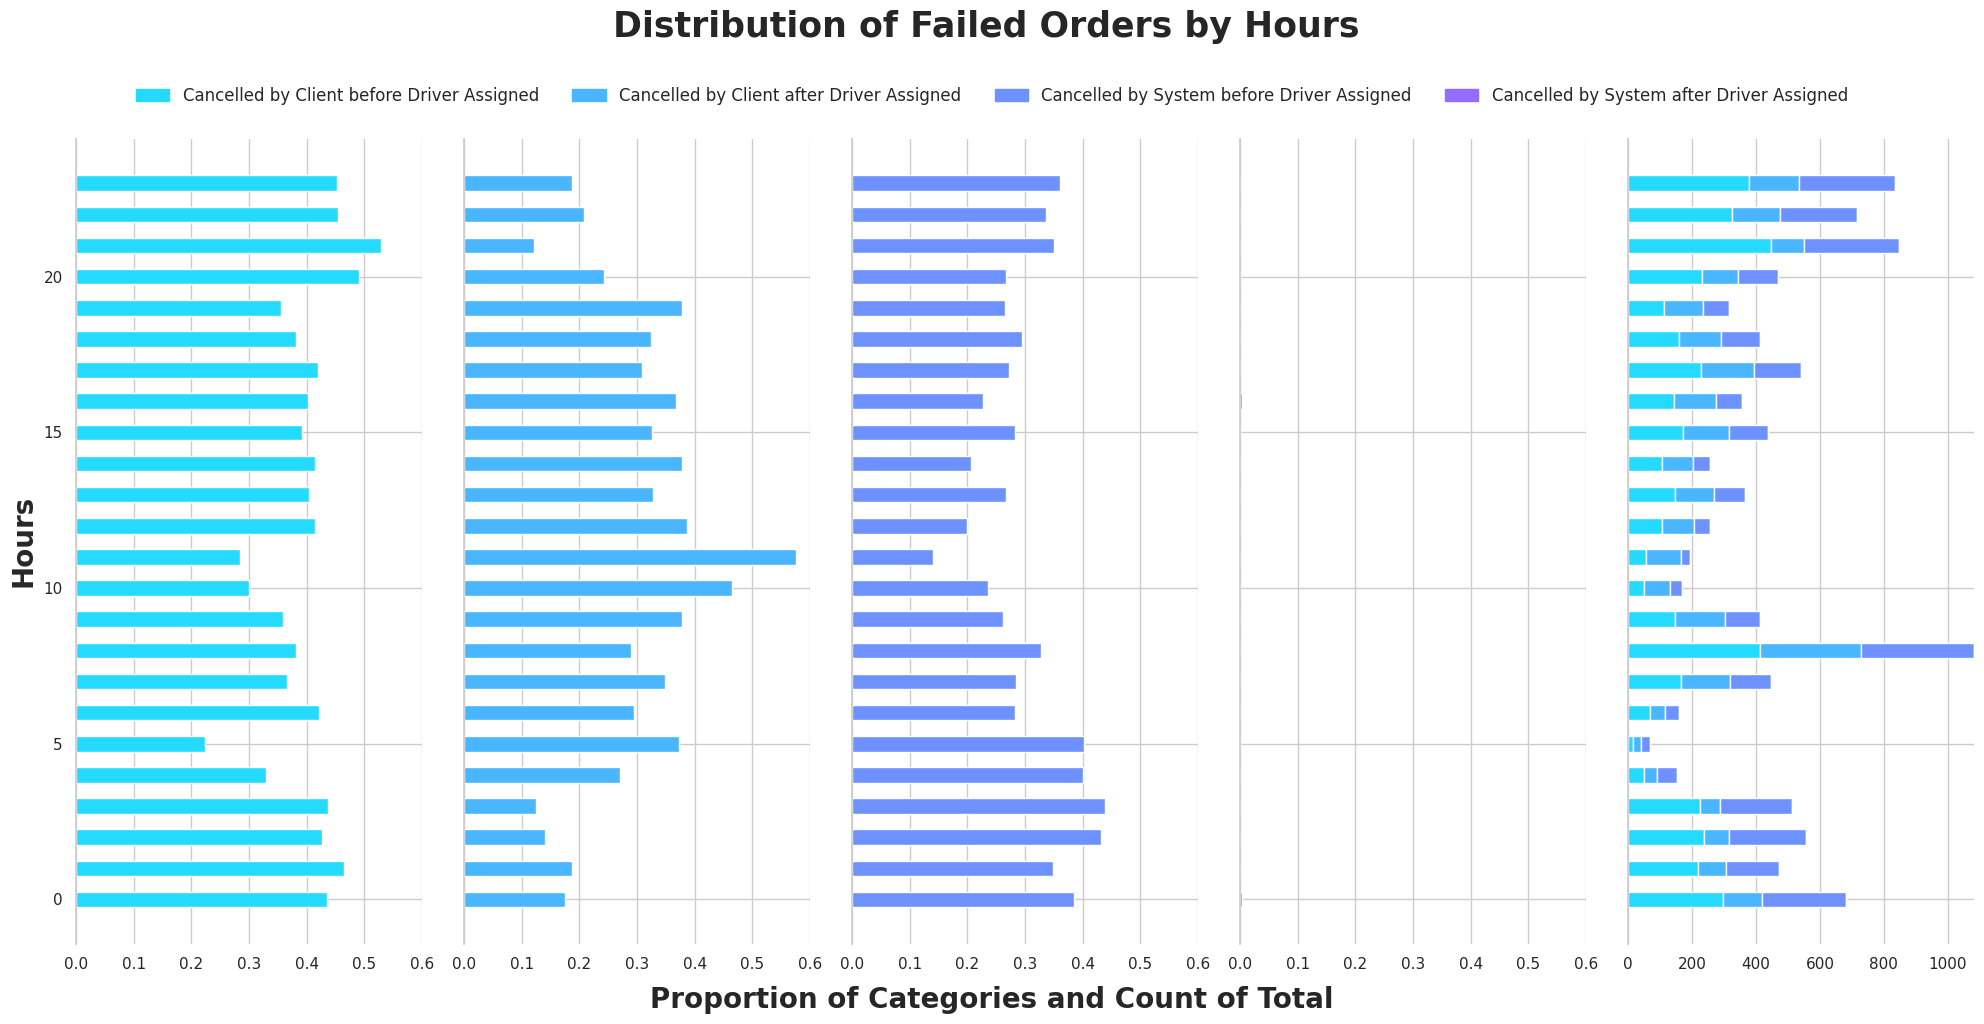

In [6]:
fig, axs = plt.subplots(1, len(reasons), figsize=(20, 10), sharey=True)
colors = sns.color_palette("cool")

patches = []
for i, ax in enumerate(axs[:-1]):  
    sns.set_theme(style='whitegrid')
    ax.barh(hours, Q2_proportion.iloc[:,i], color = colors[i],height=0.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.set_xlim(0, 0.6)
    patches.append(mpatches.Patch(color=colors[i], label=reasons[i]))

axs[-1].barh(hours, Q2.iloc[:,0], color=colors[0],height=0.5)
for i in range(1, len(reasons)-1):
    axs[-1].barh(hours, Q2.iloc[:,i], left=Q2.iloc[:,:i].sum(axis=1), color=colors[i],height=0.5)

axs[-1].spines['top'].set_visible(False)
axs[-1].spines['right'].set_visible(False)
axs[-1].spines['bottom'].set_visible(False)
axs[-1].spines['left'].set_visible(True)
    
axs[0].set_ylabel('Hours',fontsize = 20,weight='bold')
# axs[2].set_xlabel('Proportion of Catogaries and Count of Total',fontsize = 20,weight='bold')
fig.text(0.5, -0.01, 'Proportion of Categories and Count of Total', ha='center', va='center', fontsize=20, weight='bold')
    
plt.suptitle('Distribution of Failed Orders by Hours \n\n', fontsize=25, weight='bold')

fig.legend(handles=patches, bbox_to_anchor=(0.5, 0.87),loc='lower center', ncol=len(reasons), title_fontsize='13', fontsize='12',frameon=False)

plt.tight_layout()

plt.show()

In [ ]:
sns.set_theme(style='whitegrid')
colors = sns.color_palette("cool")

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x='order_hour',y= 'Cancelled by Client before Driver Assigned', data=Q2_proportion, ax=ax, label='Cancelled by Client before Driver Assigned', marker='o', markersize=5,color = colors[1])
sns.lineplot(x='order_hour',y= 'Cancelled by Client after Driver Assigned', data=Q2_proportion, ax=ax, label='Cancelled by Client after Driver Assigned', marker='o', markersize=5,color = colors[2])
sns.lineplot(x='order_hour',y= 'Cancelled by System before Driver Assigned', data=Q2_proportion, ax=ax, label='Cancelled by System before Driver Assigned', marker='o', markersize=5,color = colors[3])
sns.lineplot(x='order_hour',y= 'Cancelled by System after Driver Assigned', data=Q2_proportion, ax=ax, label='Cancelled by System after Driver Assigned', marker='o', markersize=5,color = colors[4])

ax.set_title('Proportion of Failed Orders by Hours', fontsize=20, y=1.1,fontweight='bold')
ax.set_xlabel('Hours', fontsize=15, fontweight='bold')
ax.set_ylabel('Proportion', fontsize=15, fontweight='bold')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

legend = ax.legend(bbox_to_anchor=(1.3, 0.6), loc='lower center', ncol=1, title='Driver Assigned', title_fontsize='13', fontsize='12',frameon=False)
legend.set_title(None)
ax.add_artist(legend)
plt.tight_layout()
plt.show()

By the plot above, we can find that there are actually some trend. Two categories 'Cancelled by Client before Driver Assigned' and 'Cancelled by System after Driver Assigned' maintain a stable proportion. 'Cancelled by Client after Driver Assigned' achieve an abnormally high proportion at 10:00 - 12:00, due to lots of client require but change frequently their plan during lunch break. 'Cancelled by System before Driver Assigned' reach an abnormally high proportion at 2:00 - 5:00 whose reason may be rare driver work at late night and system cancel them because no driver can be assigned.

The biggest fails happened at 8:00 - 9:00 which is the 'Morning Peak', loads of people travel and lots of orders failed.

## Q3

In [ ]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_out


In [9]:
orders['order_hour'] = pd.to_datetime(orders['order_datetime']).dt.hour
Q3_before = orders[orders['is_driver_assigned_key']==0][['order_hour','cancellations_time_in_seconds']]
Q3_after = orders[orders['is_driver_assigned_key']==1][['order_hour','cancellations_time_in_seconds']]
Q3_before = remove_outliers(Q3_before,'cancellations_time_in_seconds').groupby(['order_hour'])['cancellations_time_in_seconds'].mean()
Q3_after = remove_outliers(Q3_after,'cancellations_time_in_seconds').groupby(['order_hour'])['cancellations_time_in_seconds'].mean()


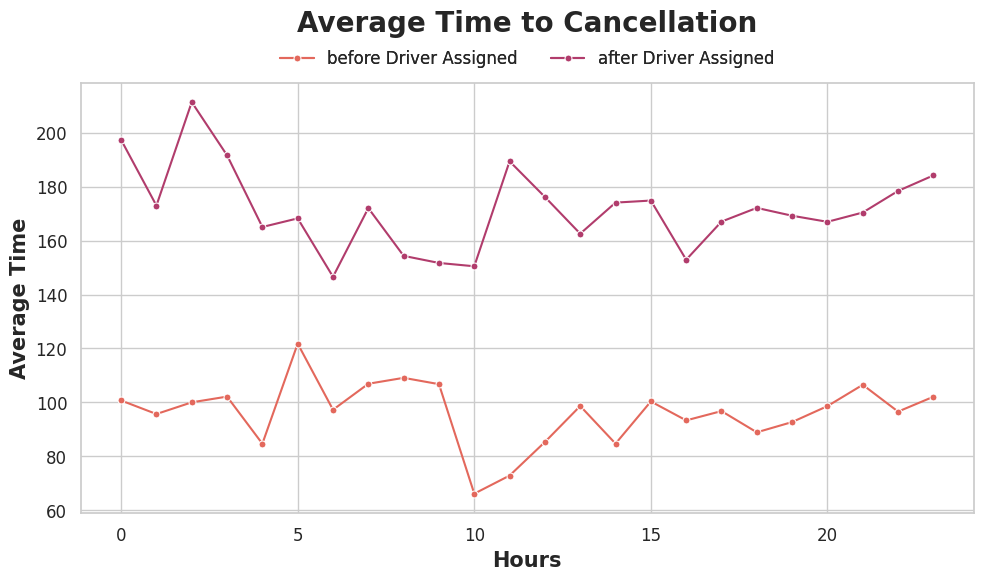

In [10]:
sns.set_theme(style='whitegrid')
colors = sns.color_palette("flare")

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=Q3_before, ax=ax, label='before Driver Assigned', marker='o', markersize=5, color=colors[1])
sns.lineplot(data=Q3_after, ax=ax, label='after Driver Assigned', marker='o', markersize=5, color=colors[3])

ax.set_title('Average Time to Cancellation', fontsize=20, y=1.1,fontweight='bold')
ax.set_xlabel('Hours', fontsize=15, fontweight='bold')
ax.set_ylabel('Average Time', fontsize=15, fontweight='bold')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

legend = ax.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2, title='Driver Assigned', title_fontsize='13', fontsize='12',frameon=False)
legend.set_title(None)
ax.add_artist(legend)
plt.tight_layout()
plt.show()

By the plot above we find 'after Driver Assigned' is higher than 'before Driver Assigned' at a whole level. For 'after Driver Assigned' orders, the average time to cancellation achieve a high level at 0:00 - 4:00. At mignight people is prone to wait because of it's hard to take a car. For 'before Driver Assigned', the average time to cancellation achieve a high level at 5:00 - 9:00. At morning peak, people are willing to waiting because of great demand.

## Q4

In [11]:
orders['order_hour'] = pd.to_datetime(orders['order_datetime']).dt.hour
Q4 = pd.DataFrame(orders.groupby(['order_hour'])['m_order_eta'].mean())

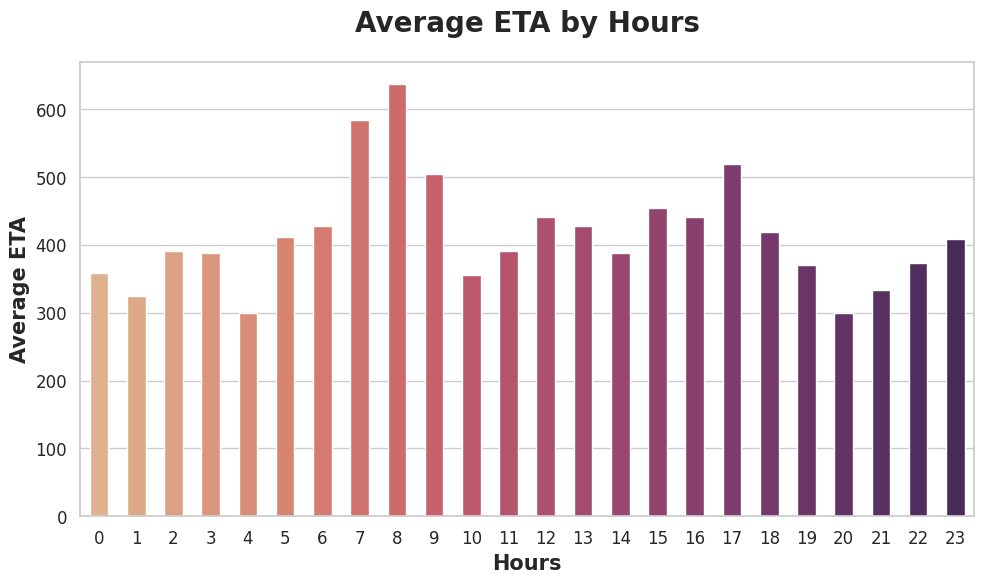

In [12]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x = 'order_hour', y = 'm_order_eta', data=Q4, palette='flare',hue='order_hour', ax=ax, legend= False, width=0.5)

ax.set_title('Average ETA by Hours', fontsize=20, y=1.05,fontweight='bold')
ax.set_xlabel('Hours', fontsize=15, fontweight='bold')
ax.set_ylabel('Average ETA', fontsize=15, fontweight='bold')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

By the plot, the tow peak happens at morning peak and evening peak when great traffic jam occurs. Thus it always takes lots of time before order arrive

## Q5

In [13]:
cumulative_orders = 0
hex_80 = []
count_80 = []

def lat_lng_to_h3(row):
    return h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8)

orders['h3'] = orders.apply(lat_lng_to_h3, axis=1)
hex_counts = orders['h3'].value_counts().sort_values(ascending=False)
total_orders = orders.shape[0]
for hex, count in hex_counts.items():
    cumulative_orders += count
    hex_80.append(hex)
    count_80.append(count)
    if cumulative_orders / total_orders >= 0.8:
        break
print(f'there are {len(hex_80)} hexagons that cover 80% of the orders')

there are 24 hexagons that cover 80% of the orders


In [15]:
cmap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=min(count_80), vmax=max(count_80)).to_step(n=10)
def get_color(count):
    return cmap(count)
map_center = [orders['origin_latitude'].mean(), orders['origin_longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=13)
cmap.caption = 'Failed Order Count'
m.add_child(cmap)
for hex in hex_80:
    polygon = h3.h3_to_geo_boundary(hex)
    color = get_color(hex_counts[hex])
    folium.Polygon(locations=polygon, color=None, fill=True, fill_color=color, fill_opacity=0.5, weight=0).add_to(m)

m